In [23]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import sys
from PIL import Image
sys.modules['Image'] = Image 
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

In [24]:
# NOTE: IF THE DATASET HASNT CHANGED AND YOU WANT TO KEEP THE SAME DATA PREPERATION TECHNIQUES AS THE ONES USED BELOW YOU CAN JUMP TO
# THE SECTION ON IMPORTING THE PICKLE FILE FORMAT.

DATADIR = 'C:\\Users\\USER\\DataScience\\waterDataset'
CATEGORIES = ["lajthiza", "qafshtama", "tepelena"]

# Defining the size of the images expected by MobileNetV2 and our dataset
IMG_SIZE = 224


# Loading images directly from the dataset folder and preprocess them.

# In this function we need to ensure our image preprocessing aligns precisely with MobileNetV2's requirements, 
# aiming for optimal model performance.
def load_images():
    image_data = []
    labels_data = []
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            if img.endswith(".jpg"):  # Ensure only .jpg files are processed
                try:
                    img_path = os.path.join(path, img)
                    image = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
                    image = img_to_array(image)
                    image = preprocess_input(image)
                    image_data.append(image)
                    labels_data.append(class_num)
                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")
    return np.array(image_data), np.array(labels_data)


# Loading the images and labels
image_data, labels_data = load_images()

# Verify the shape of loaded data
print(f"Loaded images shape: {image_data.shape}")
print(f"Loaded labels shape: {labels_data.shape}")

# Converting labels array into a corrsponding binary data suitable for best performance by the maschine learining model
num_classes = len(CATEGORIES)
labels_data = tf.keras.utils.to_categorical(labels_data, num_classes=num_classes)

# Save the dataset in a binary file to reload it easily without reprocessing each time.
with open("image_data_PreTrained.pickle", "wb") as pickle_out:
    pickle.dump(image_data, pickle_out)

with open("labels_data_PreTrained.pickle", "wb") as pickle_out:
    pickle.dump(labels_data, pickle_out)

Loaded images shape: (321, 224, 224, 3)
Loaded labels shape: (321,)


In [26]:
# Loading data from the stored pickle foramt file and converting them into numPy array
image_data = np.array(pickle.load(open("image_data_PreTrained.pickle", "rb")))
labels_data = np.array(pickle.load(open("labels_data_PreTrained.pickle", "rb")))

# Verify loaded data shapes
print(f"Loaded images shape from pickle: {image_data.shape}")
print(f"Loaded labels shape from pickle: {labels_data.shape}")

num_classes = len(CATEGORIES)
# Ensure labels are correctly shaped
labels_data = labels_data.reshape(-1, num_classes)

# Get IMG_SIZE 
IMG_SIZE = 224

# Splitting the data into training and validation sets
image_data_train, image_data_val, labels_data_train, labels_data_val = train_test_split(image_data, labels_data, test_size=0.2, random_state=42)

Loaded images shape from pickle: (321, 224, 224, 3)
Loaded labels shape from pickle: (321, 3)


In [27]:
#Initializing MobileNetV2 with pre-trained weights from ImageNet, excluding top classification layers, and specifying input shape of the images.
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freezing the base model
base_model.trainable = False

#Creating a sequential model for transfer learning
model = Sequential([
    
    # Using pre-trained weights from ImageNet for transfer learning.
    base_model,
    
    # Using GlobalAveragePooling to capture global features
    GlobalAveragePooling2D(),
    
    #Dense layer to learn complex patterns in extracted features
    Dense(128, activation='relu'),
    
    #Using dropout to randomly set the neurons to 0 to reduce noise
    Dropout(0.5),
    
    #Output layer with softmax activation for predicting probabilities across multiple classes
    Dense(num_classes, activation='softmax')
])

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


print(labels_data_train.shape)  # Should be (num_samples, num_classes)
print(labels_data_val.shape)    # Should be (num_samples, num_classes)

(256, 3)
(65, 3)


In [28]:
#Training the model 
history = model.fit(image_data_train, labels_data_train, batch_size=32, epochs=50, validation_data=(image_data_val, labels_data_val))

# Evaluating the model
val_loss, val_accuracy = model.evaluate(image_data_val, labels_data_val)
print(f'Validation accuracy: {val_accuracy * 100:.2f}%')

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 599ms/step - accuracy: 0.4389 - loss: 1.2019 - val_accuracy: 0.8615 - val_loss: 0.4859
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 409ms/step - accuracy: 0.7907 - loss: 0.5356 - val_accuracy: 0.9846 - val_loss: 0.2068
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 405ms/step - accuracy: 0.8615 - loss: 0.3566 - val_accuracy: 0.9846 - val_loss: 0.1637
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 412ms/step - accuracy: 0.9238 - loss: 0.2457 - val_accuracy: 0.9846 - val_loss: 0.1268
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 407ms/step - accuracy: 0.9395 - loss: 0.1783 - val_accuracy: 0.9846 - val_loss: 0.0981
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 383ms/step - accuracy: 0.9746 - loss: 0.0959 - val_accuracy: 0.9846 - val_loss: 0.0732
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 387ms/step - accuracy: 0.9837 - loss: 0.0781 - val_accuracy: 0.9846 - val_loss: 0.0641
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 398ms/step - accuracy: 0.9694 - loss: 0.0847 - val_accuracy: 0.9846 - val_loss

In [29]:
model.save('water_bottle_mobilenetv2_pretrained.keras')

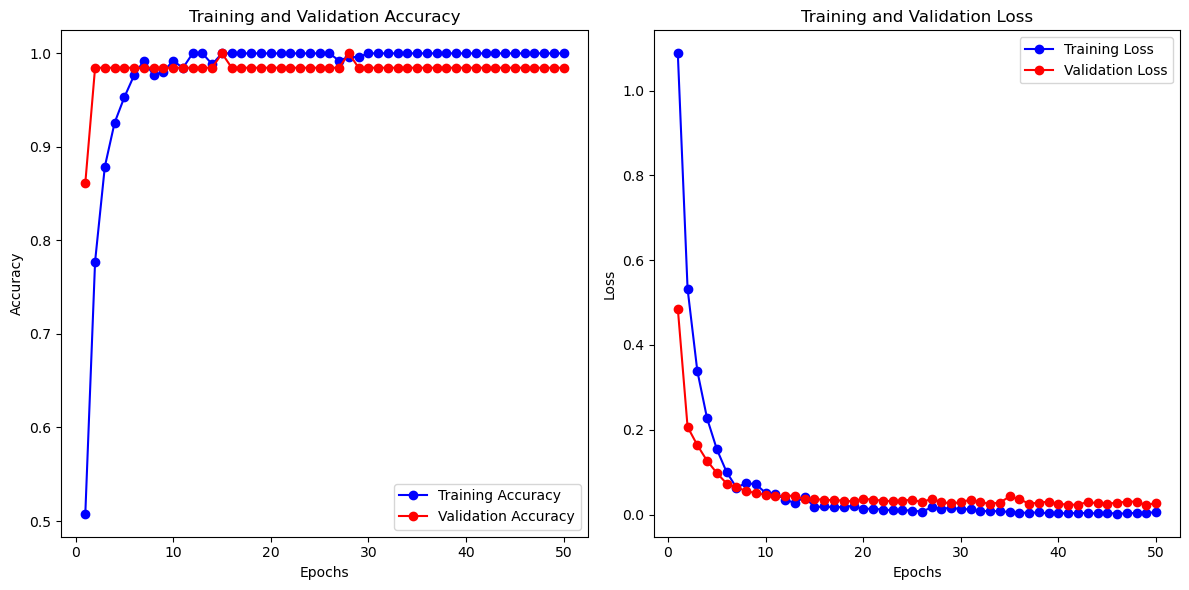

In [30]:

epochs = range(1, 51)

plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()